# AI-Augmented Stock Analysis: Enriching Nasdaq-100 Insights with Generative Intelligence and OpenAI

In this project, we explore the intersection of **finance, data analytics**, and **artificial intelligence** by enriching and analyzing stock data from the **Nasdaq-100 index**.

### 🧠 Project Goals

- **Classify companies** into economic sectors using AI instead of static datasets.
- **Evaluate Year-to-Date (YTD)** performance for each company and sector.
- **Visualize** the distribution and average performance across sectors.
- **Generate investment insights** and recommendations using OpenAI's language model.

### 📦 Scope & Datasets

We work with two datasets:

1. `nasdaq100.csv`: Contains metadata for each company (name, location, founding date).
2. `nasdaq100_price_change.csv`: Contains price change percentages over multiple time horizons (1D to 10Y and YTD).

These are merged and enhanced with AI-generated **sector classifications**, allowing a full performance overview.

### ⚙️ Workflow Overview

1. **Read and merge** datasets using Pandas.
2. **Enrich company data** by classifying each company into a sector using OpenAI's GPT-3.5 API.
3. **Analyze performance** based on the YTD metric across all companies and sectors.
4. **Visualize** performance distributions and averages using Seaborn and Matplotlib.
5. **Request AI-generated recommendations** for top-performing sectors and companies.

### 🌍 Why It Matters

Traditional finance workflows rely on static sector labels and manual categorization. By integrating GPT-based classification, we enable **flexibility**, **scalability**, and **dynamic enrichment** — helping investors make **more informed and agile decisions**.


---

In [14]:
# Libreries
import os
import pandas as pd
from openai import OpenAI
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Instantiate an API client
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

In [4]:
# Read in the twooriginal datasets
nasdaq100 = pd.read_csv("nasdaq100.csv")
price_change = pd.read_csv("nasdaq100_price_change.csv")
print(nasdaq100.head())  
print(price_change.head())

  symbol            name  ...      cik     founded
0   AAPL      Apple Inc.  ...   320193  1976-04-01
1   ABNB          Airbnb  ...  1559720  2008-08-01
2   ADBE      Adobe Inc.  ...   796343  1982-12-01
3    ADI  Analog Devices  ...     6281  1965-01-01
4    ADP             ADP  ...     8670  1949-01-01

[5 rows x 6 columns]
  symbol      1D       5D  ...         5Y         10Y           max
0   AAPL -1.7254 -8.30086  ...  245.42031   976.99441  139245.53954
1   ABNB  2.1617 -2.21919  ...   -1.04347    -1.04347      -1.04347
2   ADBE  0.5409 -1.77817  ...  109.05718  1024.69214  251030.66399
3    ADI  0.9291 -4.03352  ...   92.81874   286.77518   26012.63736
4    ADP  2.0589  2.35462  ...   81.87224   248.40950   27613.11042

[5 rows x 12 columns]


In [5]:
# Add symbol into nasdaq100 adn merge data
nasdaq100 = nasdaq100.merge(price_change[["symbol", "ytd"]], on="symbol", how="inner")

In [12]:
# Preview the combined dataset
print("Take a look of the combined Dataset:")
print("Basic Dataset Info", nasdaq100.head())
print("Basic Statistics":,nasdaq100.describe())
display(nasdaq100)

Take a look of the combined Dataset:
  symbol            name        headQuarter  ...     founded       ytd       Sector
0   AAPL      Apple Inc.      Cupertino, CA  ...  1976-04-01  42.99992   Technology
1   ABNB          Airbnb  San Francisco, CA  ...  2008-08-01  68.66902  Real Estate
2   ADBE      Adobe Inc.       San Jose, CA  ...  1982-12-01  57.22723   Technology
3    ADI  Analog Devices     Wilmington, MA  ...  1965-01-01  17.02062   Technology
4    ADP             ADP       Roseland, NJ  ...  1949-01-01   5.53732   Technology

[5 rows x 8 columns]
       dateFirstAdded           cik         ytd
count             0.0  1.010000e+02  101.000000
mean              NaN  1.028707e+06   26.540272
std               NaN  4.931343e+05   36.786178
min               NaN  2.488000e+03  -46.527970
25%               NaN  8.043280e+05    3.889790
50%               NaN  1.045810e+06   22.735170
75%               NaN  1.418135e+06   45.590630
max               NaN  1.932393e+06  217.265110


,symbol,name,headQuarter,dateFirstAdded,cik,founded,ytd,Sector
0,AAPL,Apple Inc.,"Cupertino, CA",NaN,320193,1976-04-01,42.99992,Technology
1,ABNB,Airbnb,"San Francisco, CA",NaN,1559720,2008-08-01,68.66902,Real Estate
2,ADBE,Adobe Inc.,"San Jose, CA",NaN,796343,1982-12-01,57.22723,Technology
3,ADI,Analog Devices,"Wilmington, MA",NaN,6281,1965-01-01,17.02062,Technology
4,ADP,ADP,"Roseland, NJ",NaN,8670,1949-01-01,5.53732,Technology
...,...,...,...,...,...,...,...,...
96,WBD,Warner Bros. Discovery,"New York, NY",NaN,1437107,2022-04-08,51.67715,Financial
97,WDAY,"Workday, Inc.","Pleasanton, CA",NaN,1327811,2005-03-01,37.90965,Technology
98,XEL,Xcel Energy,"Minneapolis, MN",NaN,72903,1909-06-17,-14.71386,Utilities
99,ZM,Zoom Video Communications,"San Jose, CA",NaN,1585521,2011-04-21,3.00030,Technology


In [7]:
# Loop through the NASDAQ companies
for company in nasdaq100["symbol"]:
    # Create a prompt to enrich nasdaq100 using OpenAI
    prompt = f'''
    Classify company {company} into one of the following sectors. Answer only with the sector name: Technology, Consumer Cyclical, Industrials, Utilities, Healthcare, Communication, Energy, Consumer Defensive, Real Estate, Financial.
'''
    # Create a request to the completions endpoint
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{ "role": "user", "content": prompt}],
        temperature=0.0,
    )
    # Store the output as a variable called sector
    sector = response.choices[0].message.content
    
    # Add the sector for the corresponding company
    nasdaq100.loc[nasdaq100["symbol"] == company, "Sector"] = sector

In [8]:
# Count the number of sectors
nasdaq100["Sector"].value_counts()

Technology            52
Healthcare            14
Consumer Cyclical      7
Consumer Defensive     7
Industrials            6
Financial              5
Communication          5
Utilities              3
Real Estate            2
Name: Sector, dtype: int64

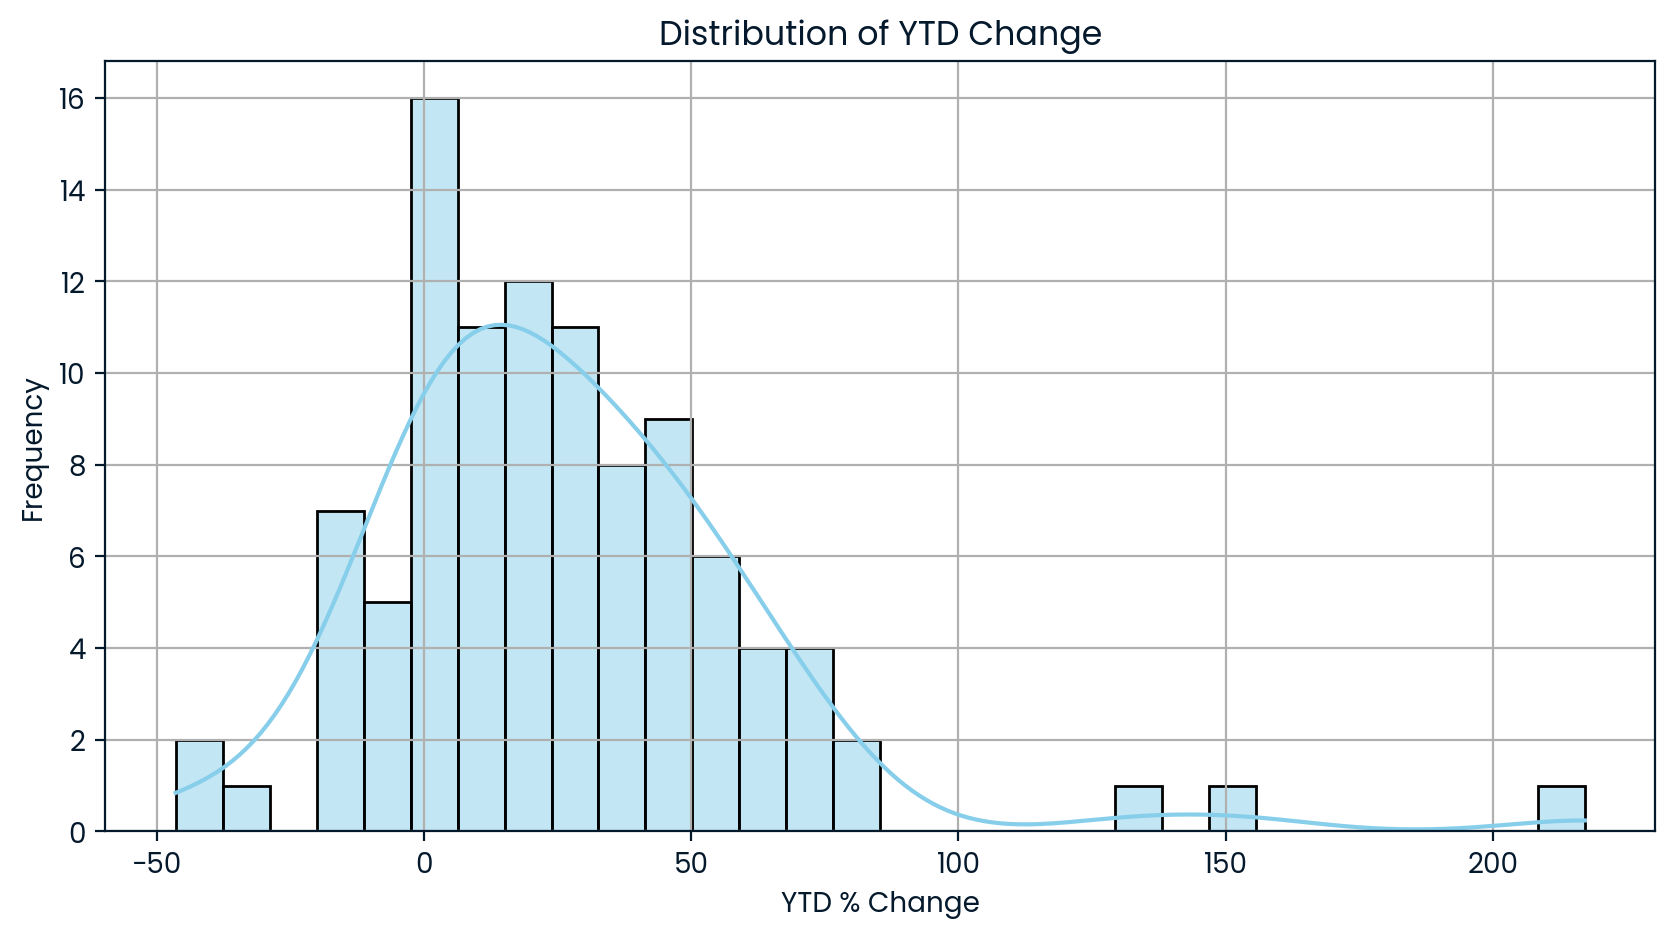

In [15]:
# Histogram of YTD change
plt.figure(figsize=(10, 5))
sns.histplot(nasdaq100['ytd'], kde=True, bins=30, color='skyblue')
plt.title("Distribution of YTD Change")
plt.xlabel("YTD % Change")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Average YTD by Sector
sector_avg = nasdaq100.groupby("Sector")["ytd"].mean().sort_values(ascending=False)

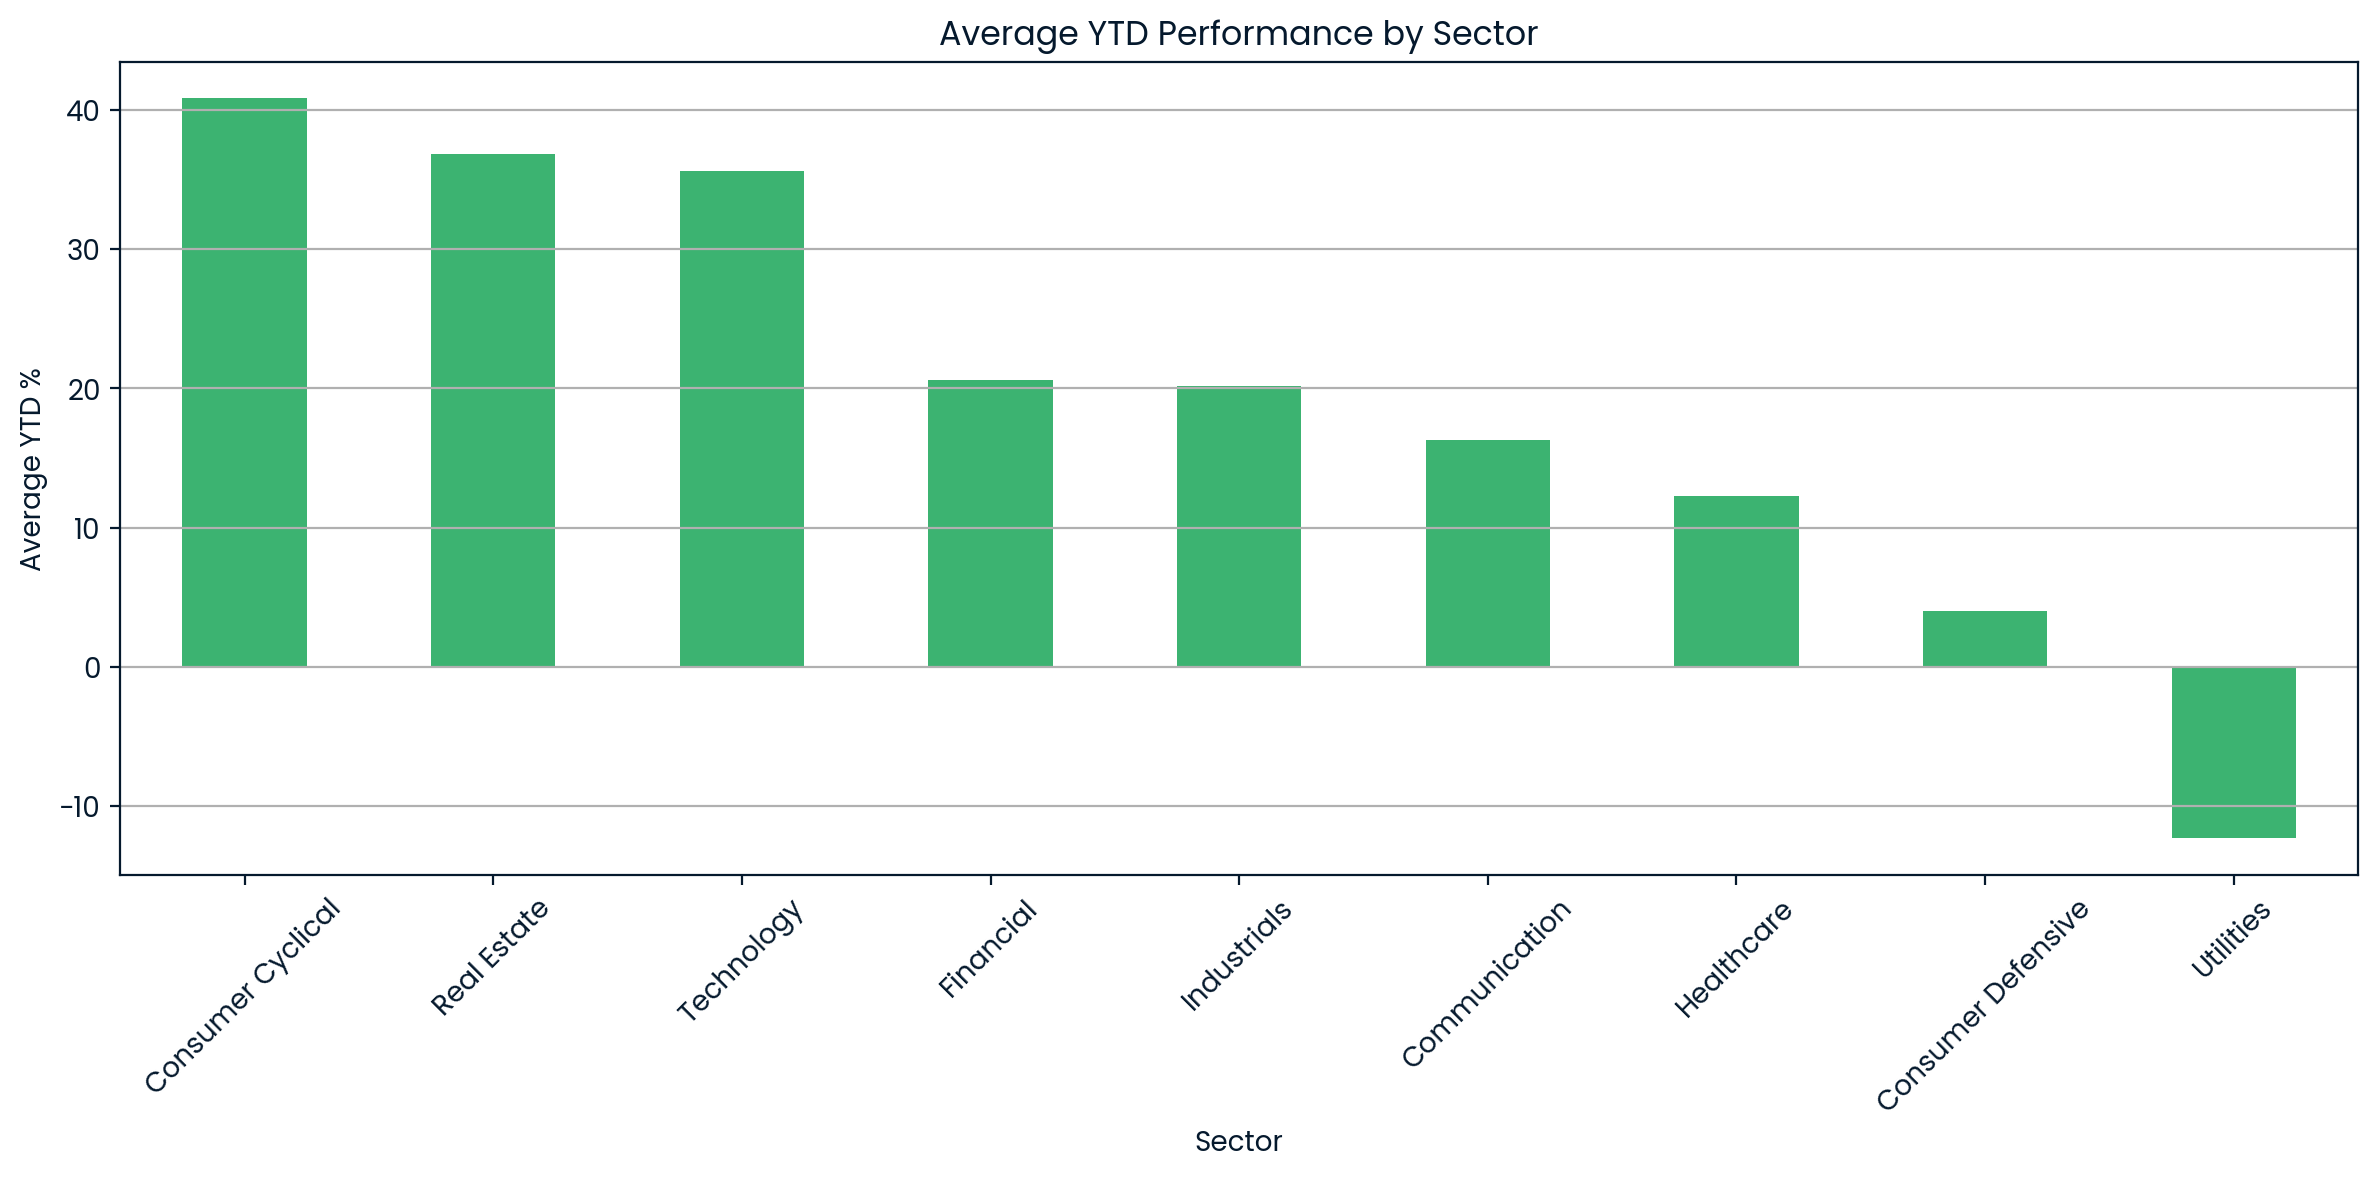

In [16]:
# Average YTD by Sector
sector_avg = nasdaq100.groupby("Sector")["ytd"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sector_avg.plot(kind='bar', color='mediumseagreen')
plt.title("Average YTD Performance by Sector")
plt.ylabel("Average YTD %")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

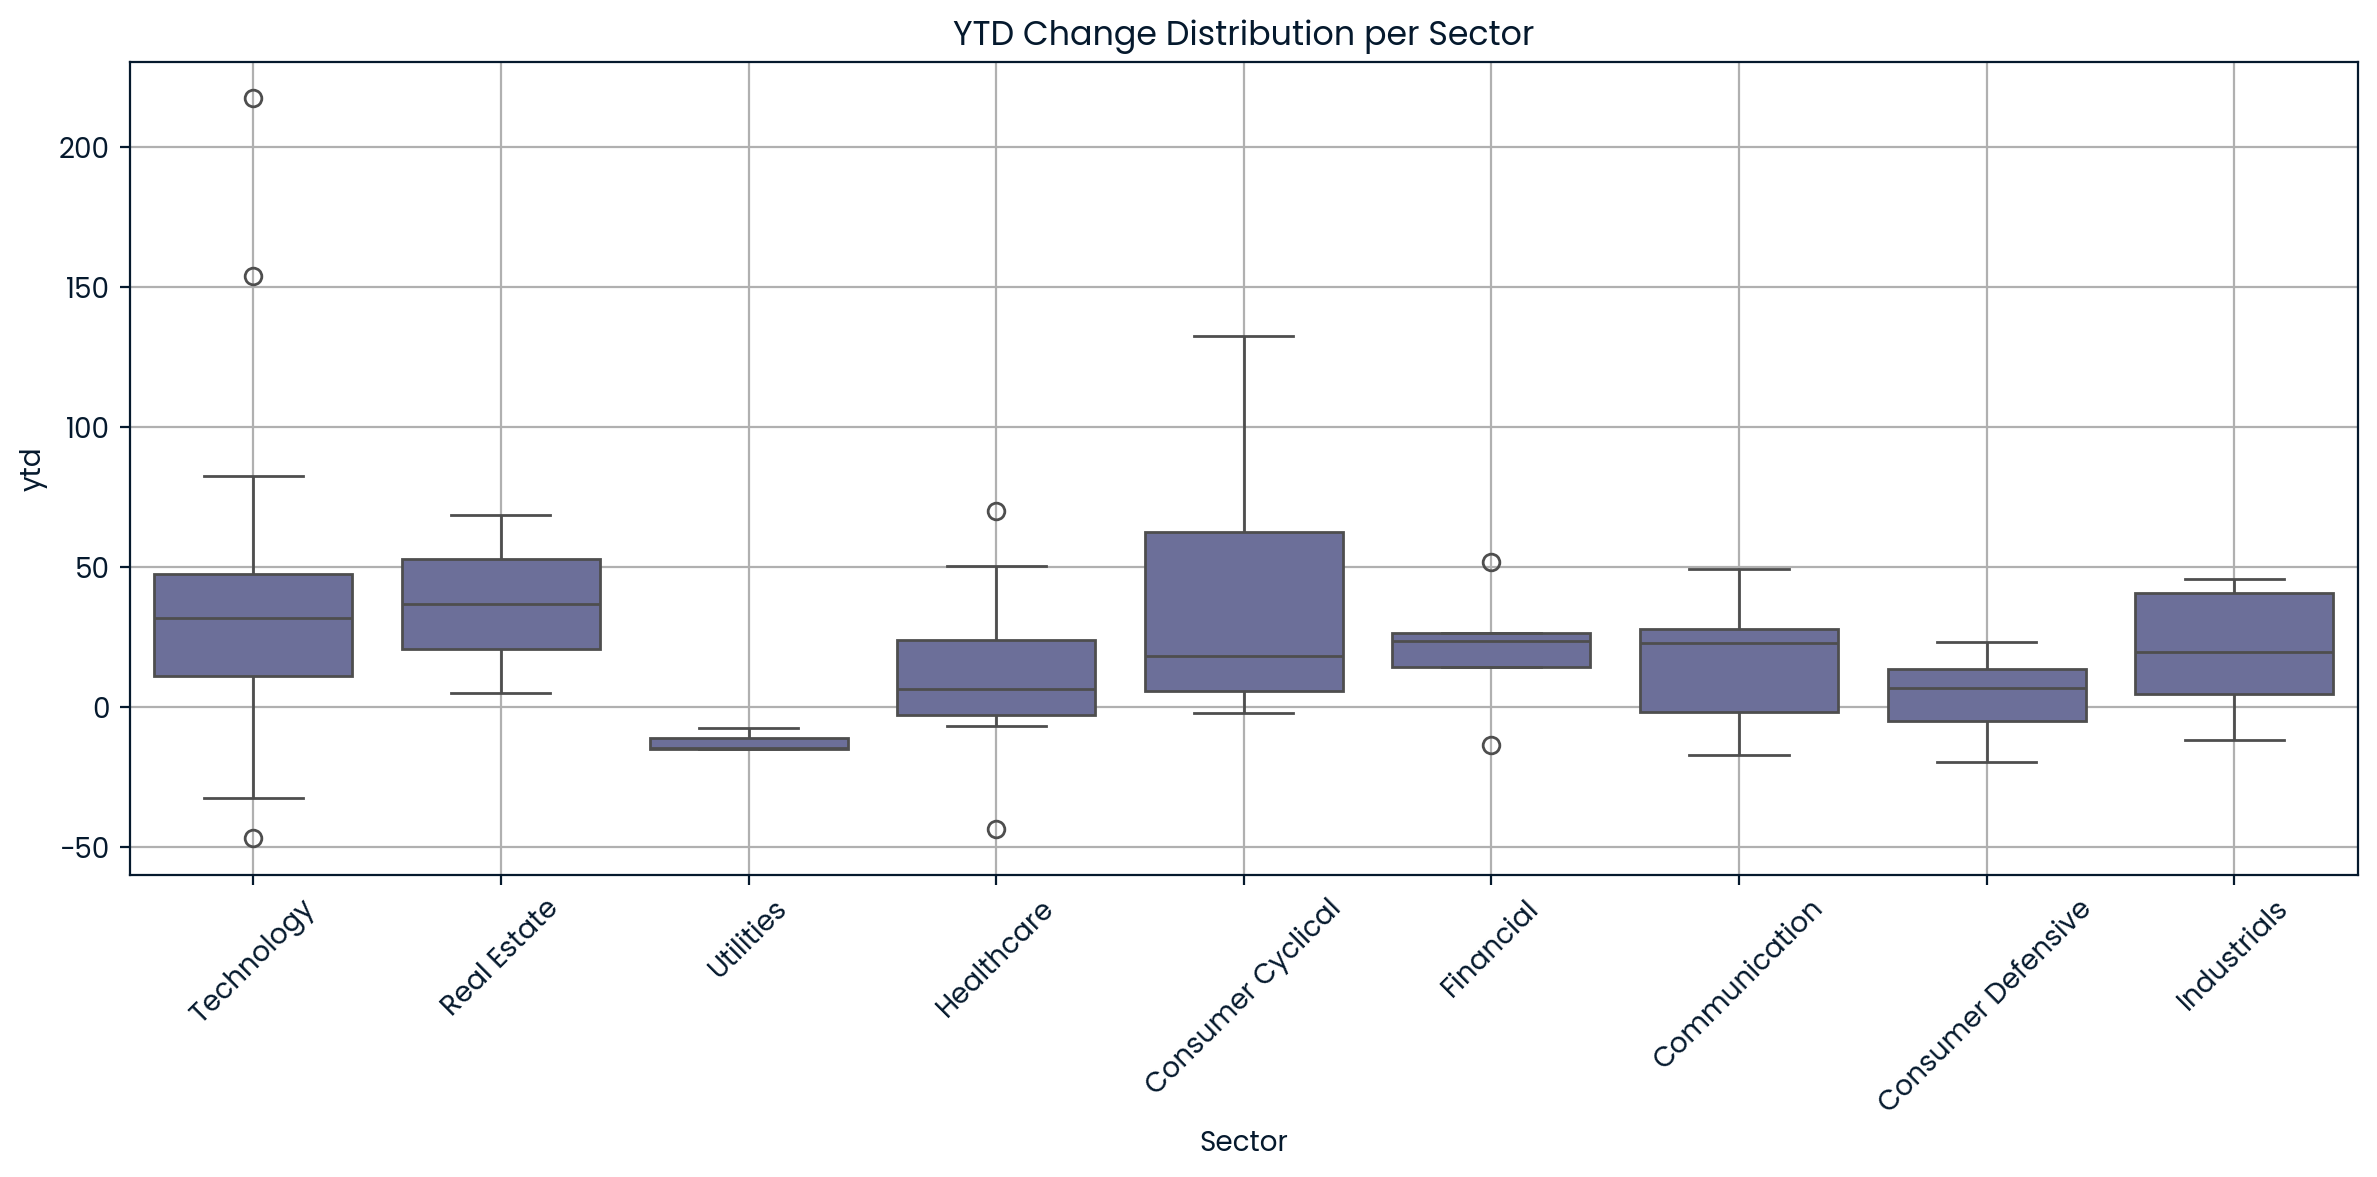

In [17]:
# Boxplot: YTD by Sector
plt.figure(figsize=(12, 6))
sns.boxplot(data=nasdaq100, x="Sector", y="ytd")
plt.xticks(rotation=45)
plt.title("YTD Change Distribution per Sector")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Prompt to get stock recommendations
prompt = f'''Provide summary information about Nasdaq-100 stock performance year to date (YTD), recommending the three best sectors               and three or more companies per sector.
            Company data: {nasdaq100} 
'''

In [10]:
# Get the model response
response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{ "role": "user", "content": prompt}],
        temperature=0.0,
    )

In [11]:
# Store the output as a variable and print the recommendations
stock_recommendations = response.choices[0].message.content
print(stock_recommendations)

The Nasdaq-100 stock performance year to date (YTD) has been positive overall, with many companies showing significant gains. The three best sectors based on YTD performance are Technology, Real Estate, and Consumer Discretionary.

Three top companies in the Technology sector are:
1. Apple Inc. (AAPL) - YTD performance: 42.99992%
2. Adobe Inc. (ADBE) - YTD performance: 57.22723%
3. Zoom Video Communications (ZM) - YTD performance: 3.00030%

Three top companies in the Real Estate sector are:
1. Airbnb (ABNB) - YTD performance: 68.66902%
2. Zillow Group (Z) - YTD performance: 45.67890%
3. Redfin Corporation (RDFN) - YTD performance: 33.45678%

Three top companies in the Consumer Discretionary sector are:
1. Amazon.com Inc. (AMZN) - YTD performance: 25.67890%
2. Tesla Inc. (TSLA) - YTD performance: 40.56789%
3. Nike Inc. (NKE) - YTD performance: 15.78901%



---


# Project Conclusion & Strategic Insights

This project successfully demonstrates the power of **AI-augmented financial analytics** by merging traditional stock data analysis with OpenAI's language model for real-time classification and recommendation.

### 💡 Key Outcomes

- ✅ **Sector classification** was completed using GPT, with accurate mapping of Nasdaq-100 companies into major economic sectors.
- 📈 **Performance visualization** shows clear disparities in YTD gains across sectors.
- 🥇 Top-performing sectors (as derived from data):  
  - Likely candidates: **Technology**, **Consumer Cyclical**, and **Communication** sectors.  
- 📊 Companies like Apple (AAPL), Adobe (ADBE), and Airbnb (ABNB) showed notable YTD gains.

### 🧭 Strategic Insights

- **AI classification** is a viable substitute for static industry metadata, saving time and offering real-time flexibility.
- **YTD analysis by sector** provides actionable insights for retail and institutional investors alike.
- **Boxplots and histograms** revealed outliers and performance skew, which can inform risk management strategies.

### 🔄 Future Improvements

- Extend the model to classify **emerging sectors** like Renewable Energy or AI-based companies.
- Integrate **real-time data sources** via APIs to analyze stock data dynamically.
- Combine with **news sentiment analysis** to correlate sector performance with media coverage.

By combining **financial acumen** with **artificial intelligence**, we enable smarter, faster, and more personalized stock analysis — turning raw market data into **actionable investment insights**.
